# Problem 4

In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<a href="javascript:code_toggle()">
<button>Toggle Code</button></a>''')

In [2]:
# import libraries
import time
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt

# set random seed
np.random.seed(1000)

In [3]:
# import mnist data
mnist = sio.loadmat('mnist_all.mat')

# split training and test data
training_data = dict()
test_data = dict()
for key in mnist:
    if "train" in key:
        # store the data under digit key
        training_data[int(key[-1])] = mnist[key]
    if "test" in key:
        # store the data under digit key
        test_data[int(key[-1])] = mnist[key]

In [4]:
"""
    Format Data
"""
# Define function for formatting data and labels
def format_data(data_input):
    # unpack input into data and labels
    data = np.zeros((0,data_input[0].shape[1]))
    labels = np.zeros((0,len(data_input)))
    for number in data_input:
        # concatenate data of each digit to array
        data = np.concatenate((data,data_input[number]),axis=0)

        # create labels
        lb = (np.zeros((data_input[number].shape[0],len(data_input))))
        lb[:,number] = 1

        # concatenate labels to array
        labels = np.concatenate((labels,lb),axis=0)
        
    # scale data from [0,255] to [0,1]
    data = data/255

    # add bias term to data_input
    bias = np.ones((data.shape[0],1))
    data = np.concatenate((bias,data),axis=1)
    
    # return data and labels
    return data, labels

In [5]:
"""
    Define Neural Network Class

"""
class NeuralNetwork:
    """
        Create a class that defines a neural network
    """
    def __init__(self,data_input,test_input,lr=1e-4,layers=(10,),iterations=1000):
        """
            Initialize the network
        """
        # format data
        self.data, self.labels = format_data(data_input)
        self.test_data, self.test_labels = format_data(test_input)
        
        # Save learning rate and iterations
        self.lr = lr
        self.iterations = iterations
        
        # Create list to hold weights in each layer
        self.weights = list()
        
        # Initialize weights in each layer
        for n,layer in enumerate(layers):
            if n == 0:
                # set appropriate dimensions for input layer 
                self.weights.append(np.random.randn(self.data.shape[1],layer)*0.01+0.05)
            else:
                # set appropriate dimensions for each hidden layer
                self.weights.append(np.random.randn(layers[n-1],layer)*0.01+0.05)
        
        # Add final output layer to weights
        self.weights.append(np.random.randn(layers[-1],self.labels.shape[1])*0.01+0.05)
        
        # Display the network dimensions
        print("Input: {}".format(self.data.shape))
        for n,w in enumerate(self.weights):
            print("Layer{}: {}".format(n,w.shape))
        
        # Save MSE
        self.MSE = list()
        self.test_MSE = list()
        self.test_class_error = list()
        
    def _feedforward(self,data):
        """
            Do feedforward pass on network
        """
        # save output of each layer into a list
        output = list()
        
        # loop over each layer and apply forward pass
        # save output from each layer
        for n,w in enumerate(self.weights):
            if n == 0: # set input to data
                output.append(self._logistic(np.dot(data,w)))
            else: # just use last output
                output.append(self._logistic(np.dot(output[n-1],w)))
        
        # return the output
        return output
    
    def _backpropagation(self,output):
        """
            Do backpropagation to calculate gradients
        """
        # calculate error between final output and labels
        error = self.labels - output[-1]
        
        # store MSE
        self.MSE.append((1/error.shape[0])*(np.linalg.norm(error,axis=0)**2))
        
        # calculate gradients of each layer
        gradients = list()
        gradients.append(error*self._dlog(output[-1])) # add final layer gradient
        
        # calculate gradients of other layers
        for n in reversed(range(len(self.weights)-1)):
            # grab gradient from forward layer, dot with weights,
            # and multiply into current gradient
            gradients.append(self._dlog(output[n])*np.dot(gradients[-1],self.weights[n+1].T))
    
        # reverse gradient list
        gradients = gradients[::-1]
        
        # update new weights
        for i,grad in enumerate(gradients):
            if i == 0:
                self.weights[i] += self.lr*np.dot(self.data.T, grad)
            else:
                self.weights[i] += self.lr*np.dot(output[i-1].T, grad)
        
    @staticmethod
    def _logistic(data):
        """Logistic Function"""
        return 1/(1 + np.exp(-data))
    
    @staticmethod
    def _dlog(output):
        """Derivative of Logistic Function"""
        return output*(1-output)
    
    def train(self):
        """
            Train the neural network
        """
        # Loop over iterations
        for i in range(self.iterations):
            # do forward pass
            output = self._feedforward(self.data)
        
            # do backpropagation and update gradients
            self._backpropagation(output)
            
            # apply to test set
            test_stats = self._apply()
            self.test_MSE.append(test_stats[2])
            self.test_class_error.append(test_stats[3])
            
            # print iteration
            if (i+1) % 100 == 0:
                print("Finished Iteration {}, MSE: {}".format(i,self.MSE[-1]))
        
        # return output and classes
        return (output[-1], np.argmax(output[-1],axis=1)),test_stats 
    
    def _apply(self):
        """
            Apply model to data
        """        
        # do forward pass
        output = self._feedforward(self.test_data)
        
        # calculate error between final output and labels
        error = self.test_labels - output[-1]
        
        # store MSE
        MSE = (1/error.shape[0])*(np.linalg.norm(error,axis=0)**2)
        
        # get classifications
        classifications = np.argmax(output[-1],axis=1)
        test_class = np.argmax(self.test_labels,axis=1)
        
        # calculate classification error between final output and labels for each digit
        class_error = list()
        for i in range(10):
            idx = np.argwhere(test_class==i)
            class_error.append((1/test_class[idx].shape[0])*np.sum(test_class[idx] != classifications[idx]))
            
        # calculate classification error between final output and labels for all digits
        all_error = (1/test_class.shape[0])*np.sum(test_class != classifications)
        
        # return output, classes, and erros
        return output[-1], classifications, MSE, class_error, all_error

In [6]:
"""
    Train Neural Network
"""
# Create Neural Network
nn = NeuralNetwork(training_data,test_data)
training_stats,test_stats = nn.train()

Input: (60000, 785)
Layer0: (785, 10)
Layer1: (10, 10)
Finished Iteration 99, MSE: [0.09803127 0.09030702 0.09834118 0.10106278 0.0963285  0.08970523
 0.0977249  0.10179118 0.096725   0.09803475]
Finished Iteration 199, MSE: [0.09382804 0.01536743 0.09121165 0.09187902 0.07882009 0.08439562
 0.09117999 0.06978791 0.08709561 0.07421357]
Finished Iteration 299, MSE: [0.03200424 0.00999154 0.08321525 0.05783366 0.04539173 0.07996905
 0.06277681 0.02416529 0.0550979  0.05557294]
Finished Iteration 399, MSE: [0.02053916 0.00864589 0.04003289 0.03568695 0.02370266 0.05293158
 0.02768356 0.02432181 0.04266816 0.0343653 ]
Finished Iteration 499, MSE: [0.01758991 0.00804451 0.02906205 0.03041215 0.01891216 0.03697163
 0.02192865 0.02109149 0.03754186 0.0290419 ]
Finished Iteration 599, MSE: [0.01466062 0.00763976 0.02510377 0.02700852 0.01731446 0.03150126
 0.01848667 0.01929073 0.03122176 0.02453943]
Finished Iteration 699, MSE: [0.013037   0.00740968 0.02253011 0.02564751 0.01639801 0.0289044

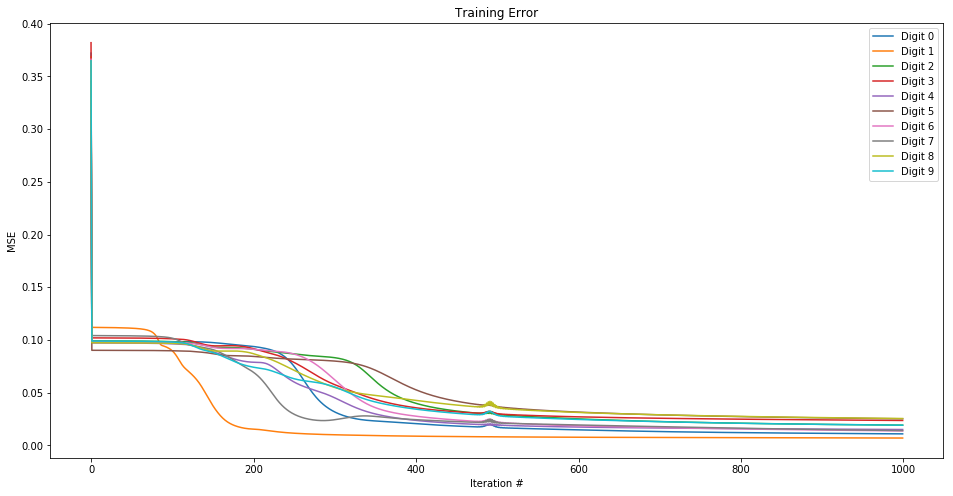

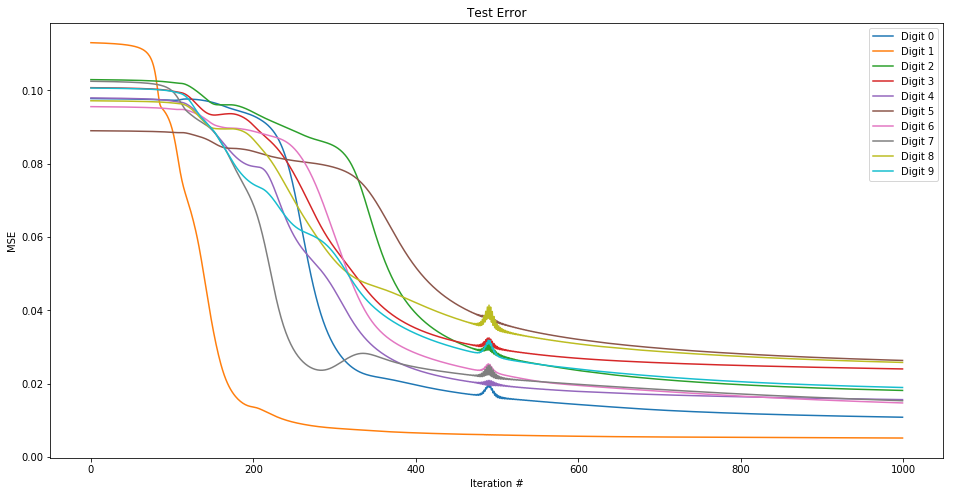

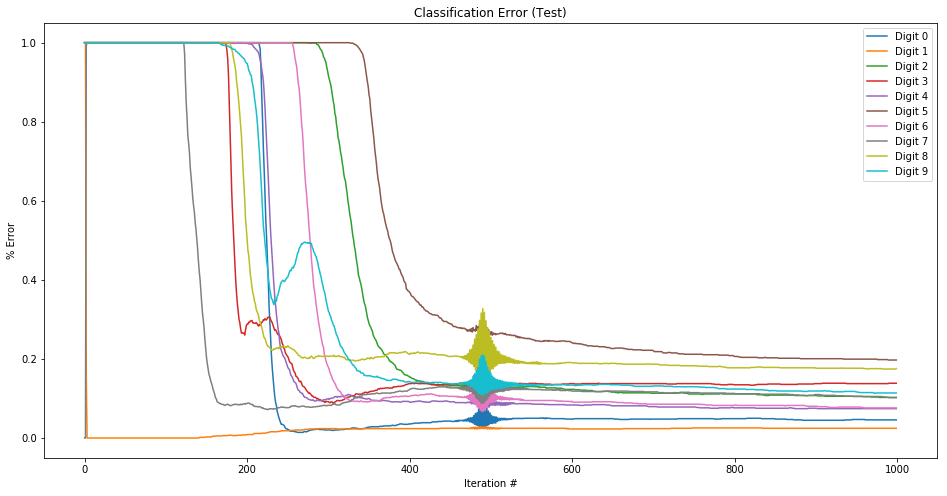

In [7]:
# Plot Training Error
MSE = np.array(nn.MSE)
plt.figure(figsize=(16,8))
for i in range(10):
    plt.plot(MSE[:,i],label='Digit {}'.format(i))
plt.title('Training Error')
plt.xlabel('Iteration #'); plt.ylabel('MSE')
plt.legend()

# Plot Test Error
test_MSE = np.array(nn.test_MSE)
plt.figure(figsize=(16,8))
for i in range(10):
    plt.plot(test_MSE[:,i],label='Digit {}'.format(i))
plt.title('Test Error')
plt.xlabel('Iteration #'); plt.ylabel('MSE')
plt.legend()

# Plot Test Classification Error
test_class_error = np.array(nn.test_class_error)
plt.figure(figsize=(16,8))
for i in range(10):
    plt.plot(test_class_error[:,i],label='Digit {}'.format(i))
plt.title('Classification Error (Test)')
plt.xlabel('Iteration #'); plt.ylabel('% Error')
plt.legend()

# Plot Plots
plt.show()

In [8]:
# Print final test errors
final_test_class_error = pd.DataFrame([test_stats[3]], index=['% Error'],
    columns=['{}'.format(str(i)) for i in range(10)])
final_overall_error = test_stats[4]

print('Final % Classification Error (Test Set):')
print(final_test_class_error)
print('\nFinal Overall % Classification Error (Test Set): {:.2f}'.format(final_overall_error))

Final % Classification Error (Test Set):
                0        1         2         3         4         5       6  \
% Error  0.045918  0.02467  0.102713  0.138614  0.074338  0.197309  0.0762   

               7         8         9  
% Error  0.10214  0.175565  0.113974  

Final Overall % Classification Error (Test Set): 0.10
